#  Data Download Guide

The Cancer Genome Atlas (TCGA) provides a comprehensive dataset from 11,315 cases across 33 cancer types, accessible via the National Cancer Institute's (NCI) Genomic Data Commons (GDC) portal (https://gdc.cancer.gov/). The GDC offers standardized data on clinical, proteomic, epigenomic, and genomic information for research purposes, enabling exploratory analyses. The GDC helps researchers uncover key cancer-driving alterations, including mutations, copy number variations, and protein expression changes.

The criterion of dataset selection
mainly considers:
(i) the number of available patients
(ii) whether having been adopted in previous publications

The sub-projects selected are:
- `TCGA-BRCA`
- `TCGA-LGG`



To collect the necessary data, follow these steps on the official TCGA website: [https://portal.gdc.cancer.gov/](https://portal.gdc.cancer.gov/):  

## 1. **Access the Cohort Builder**  
   - Click on the **Cohort Builder**.  
   - Under **Programs**, select **TCGA**. You will see 33 projects corresponding to different cancer types.  
   - Choose one of the desired projects (e.g., **TCGA-BRCA**) and save the cohort as **TCGA-BRCA**.  
   - Repeat this process for each cancer type from which you want to download data (see the figure below for reference).  



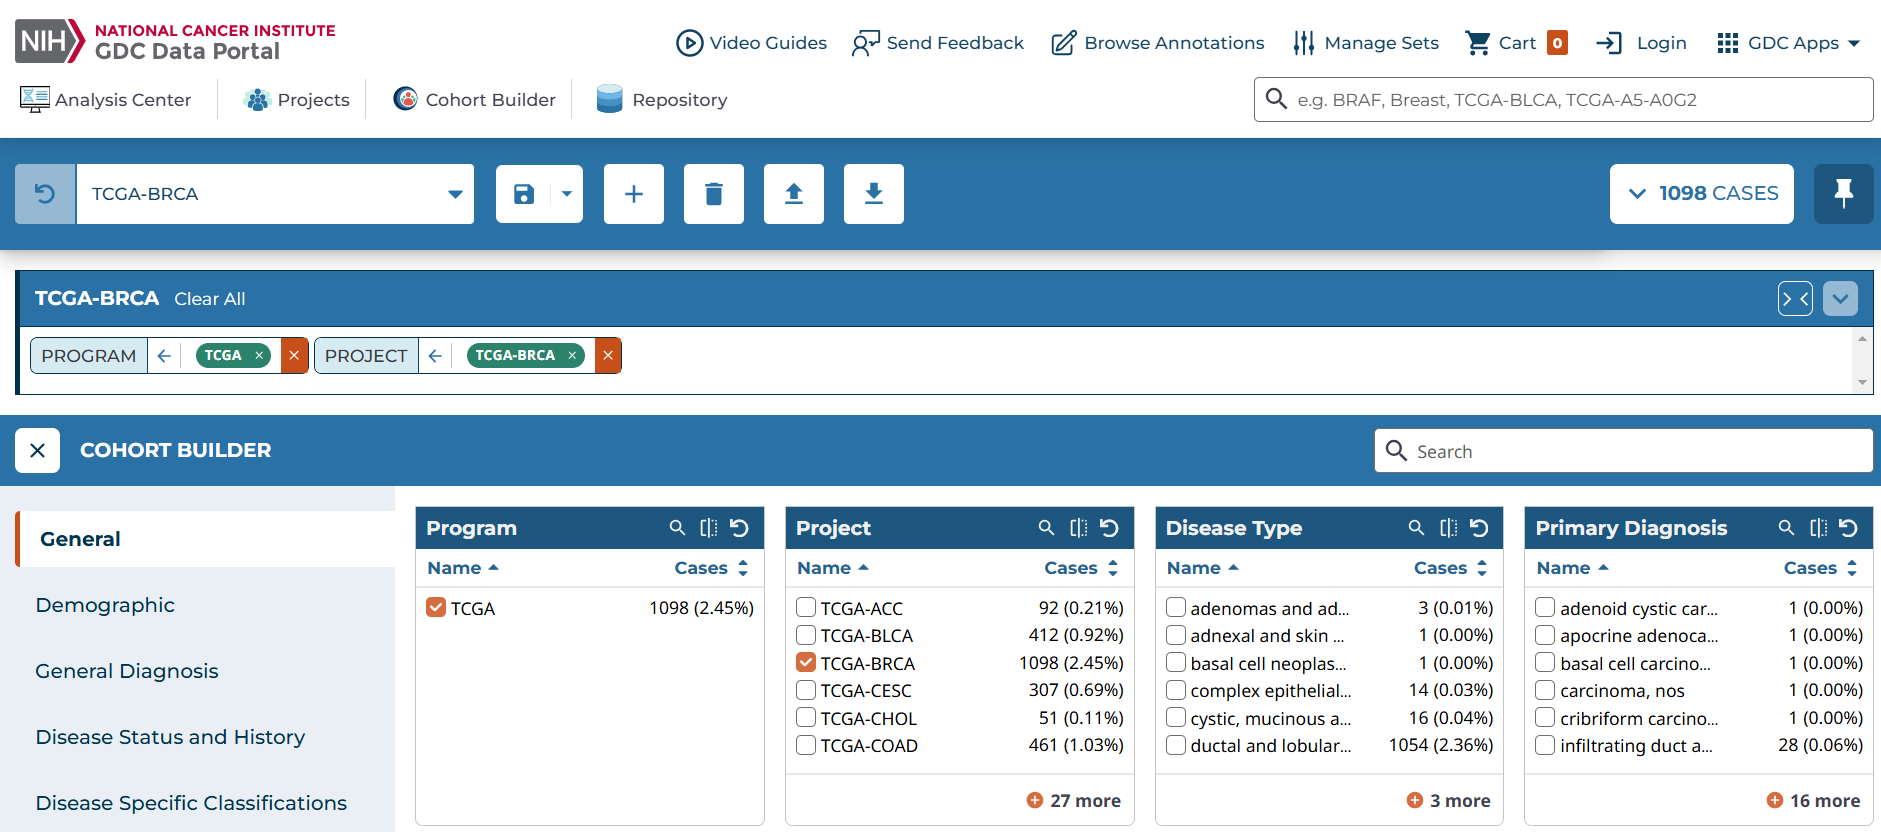

In [5]:
from IPython.display import Image, display
display(Image(filename="Fig/gdc.png"))


## 2. **Navigate to the Repository and Select Filters**  
   - Click on the **Repository** tab.  
   - On the left-hand side of the screen, various filters will be displayed. Select the appropriate filters based on the type of data you want to download (refer to the figure below for guidance).  

   **General Setup**:  
   - Begin by selecting `Access: Open`.  

   **Downloading Data**:  

   - **DNA Methylation Data**:  
     - Set `Experimental Strategy` to `Methylation Array`.  
     - Set `Data Format` to `txt`.  

   - **miRNA-seq Data**:  
     - Set `Experimental Strategy` to `miRNA Expression Quantification`.  

   - **RNA-seq Data**:  
     - Set `Experimental Strategy` to `RNA-Seq`.  

   - **Copy Number Variation (CNV) Data**:  
     - Set `Data Category` to `Copy Number Variation`.  
     - Set `Workflow Type` to `ABSOLUTE LiftOver`.  

   - **Image Data**:  
     - Set `Experimental Strategy` to `Tissue Slide`.  


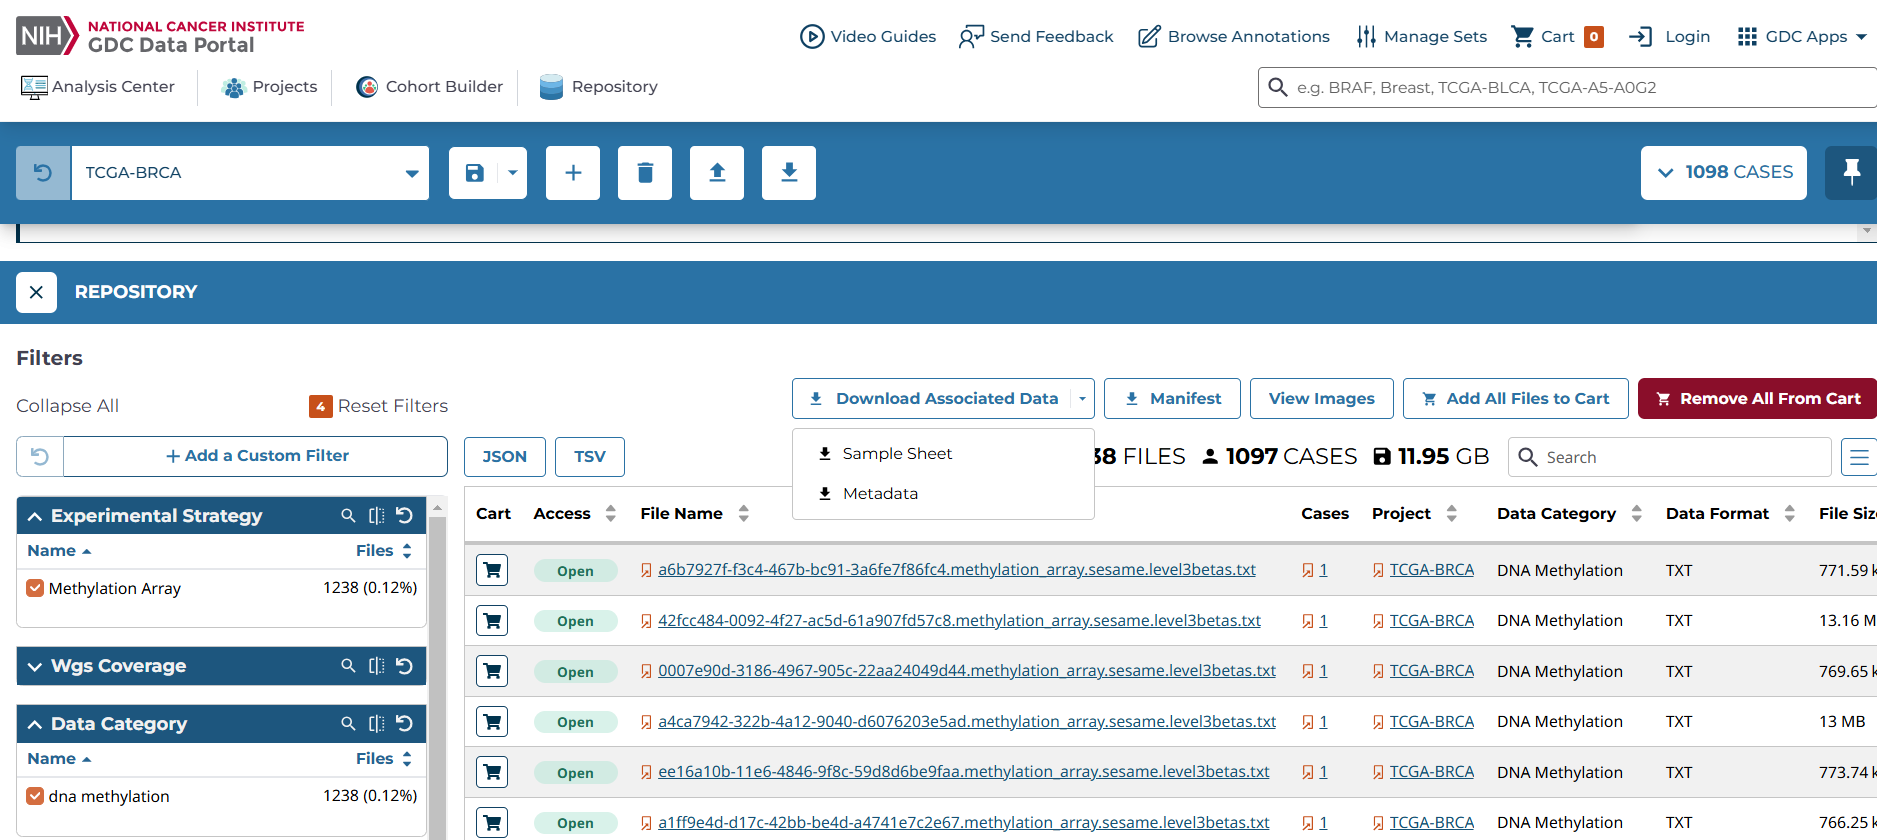

In [6]:
display(Image(filename="Fig/gdc2.png"))

**Adding to the Cart and Downloading Clinical Data:**  
For any of the filters above, once the desired datasets are identified, click **Add to Cart** to include them.  

Once in the cart, click on **Download Associated Data**.  
Select **Clinical: TSV** to download the associated clinical data in TSV format, as shown in the figure below.

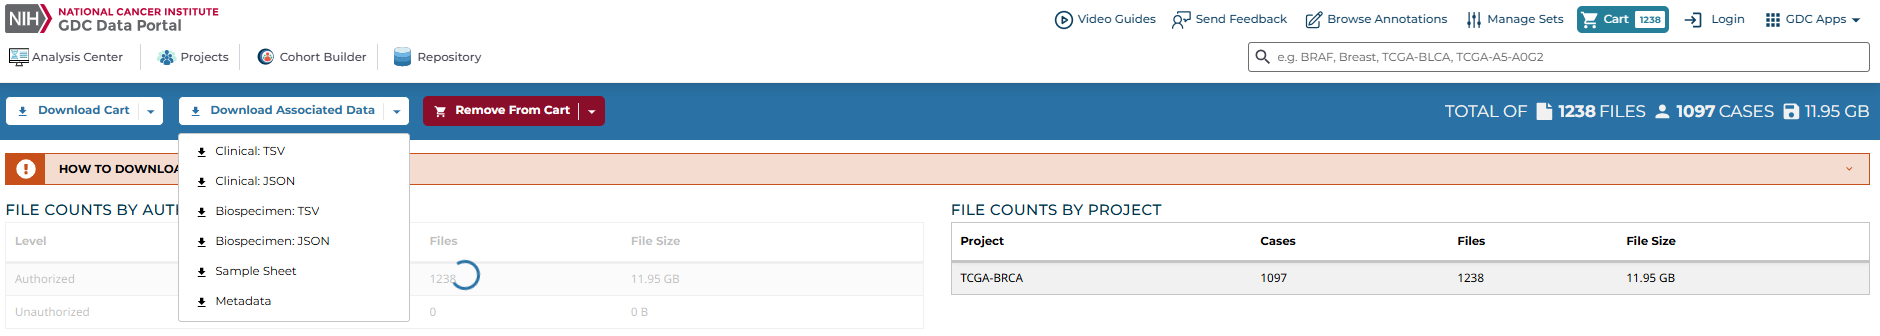

In [7]:
display(Image(filename="Fig/gdc3.png"))


## 3. Downloading the Sample Sheet and the Manifest

You should click on `Download Associated Data`, then the `Sample Sheet` button and then choose `tsv`. Then, a tsv file named `gdc_sample_sheet.XXXXXX.tsv` will be downloaded. To download the Manifest, you should click the `Download` button and then choose `Manifest`. Then, a text file named `gdc_manifest_XXXXXXXX.txt` will be downloaded.

### Organizing Downloaded Files  

After downloading the datasets for each data type (e.g., DNA Methylation, miRNA-seq, RNA-seq, CNV, and Image Data), ensure that all **Sample Sheets** for the selected cancer type are placed in the same directory, organized under `Sample_sheets/<cancer_type>`. Similarly, store all the **Manifest Files** in a separate directory under `Manifest/<cancer_type>`. 

## 4 Filter Patients by Common Case IDs

This script processes Sample Sheets and manifest files related to cancer data. It filters the Sample Sheets to retain only the rows with common indices across all files, ensuring that only patients with data across all available modes (e.g., clinical, WSI, RNAseq, etc.) are included. Using these filtered indices, the script aligns and filters the manifest files, ensuring their rows match the order of the filtered Sample Sheets. The filtered manifest files are then saved in a designated directory.

In [5]:
import pandas as pd
import os

def filter_cancer_data(base_dir, cancer_type):
    # Define paths for Sample Sheets y Manifest files
    cancer_dir = os.path.join(base_dir, "Sample_sheets", cancer_type)
    manifest_dir = os.path.join(base_dir, "Manifest", cancer_type)
    output_dir = os.path.join(manifest_dir, "filtered_manifest")
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    file_keys = ["clinical", "adn", "cnv", "miRNA", "RNAseq", "wsi"]  # Base keys
   
    
    # List TSV files in Sample Sheets directory and filter by existing files
    sample_sheet_files = [f for f in os.listdir(cancer_dir) if f.endswith(".tsv")]
    sample_sheet_paths = {key: os.path.join(cancer_dir, f) 
                          for key, f in zip(file_keys, sample_sheet_files) 
                          if f in sample_sheet_files}  # Ensure files exist

    # Read Sample Sheets into DataFrames
    dfs_sample_sheets = {}
    for key, path in sample_sheet_paths.items():
        try:
            dfs_sample_sheets[key] = pd.read_csv(path, sep="\t")
        except Exception as e:
            print(f"Error reading {path}: {e}")

    # Find common indices across all Sample Sheets
    common_indices = set.intersection(*[set(df.index) for df in dfs_sample_sheets.values()])
    print(f"Number of common cases for {cancer_type}: {len(common_indices)}")
    
    # Filter and sort Sample Sheets based on the common indices
    dfs_filtered_sample_sheets = {}
    for key, df in dfs_sample_sheets.items():
        df_filtered = df.loc[list(common_indices)].sort_index().reset_index(drop=True)
        dfs_filtered_sample_sheets[key] = df_filtered

    # Filter and sort Manifest files using indices from filtered Sample Sheets
    for key in file_keys:
        manifest_file = os.path.join(manifest_dir, f"gdc_manifest.{key}.txt")
        if os.path.exists(manifest_file):
            try:
                # Read the manifest file
                df_manifest = pd.read_csv(manifest_file, sep="\t")
                
                # Get the common indices from the filtered Sample Sheets
                filtered_indices = dfs_filtered_sample_sheets[key].index
                
                # Filter the manifest file using the common indices
                df_manifest_filtered = df_manifest.iloc[filtered_indices].reset_index(drop=True)
                
                # Save the filtered manifest file
                output_path = os.path.join(output_dir, f"filtered_gdc_manifest.{key}.txt")
                df_manifest_filtered.to_csv(output_path, sep="\t", index=False)
                print(f"Filtered manifest file saved at: {output_path}")
            except Exception as e:
                print(f"Error processing {manifest_file}: {e}")
        else:
            print(f"Manifest file not found: {manifest_file}")


In [6]:
base_dir = os.getcwd()
cancer_types = ["LGG", "BRCA"]

for cancer_type in cancer_types:
    print(f"Processing {cancer_type}...")
    filter_cancer_data(base_dir, cancer_type)

Processing LGG...
Number of common cases for LGG: 520
Filtered manifest file saved at: /home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.clinical.txt
Filtered manifest file saved at: /home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.adn.txt
Filtered manifest file saved at: /home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.cnv.txt
Filtered manifest file saved at: /home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.miRNA.txt
Filtered manifest file saved at: /home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.RNAseq.txt
Filtered manifest file saved at: /home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.wsi.txt
Processing B

For **Clinical Data**, we will use the file saved as `filtered_gdc_manifest.clinical.txt`, which contains the filtered and formatted clinical information. For all other data types (e.g., DNA Methylation, miRNA-seq, RNA-seq, CNV, and Image Data), follow the next step.

## 5. Downloading Data Using GDC Data Transfer Tool

To efficiently download data from TCGA, it is recommended to install the [GDC Data Transfer Tool](https://gdc.cancer.gov/access-data/gdc-data-transfer-tool) on your server. This tool is designed for streamlined data transfers. In my case, I used version `gdc-client_2.3.0_Ubuntu_x64-py3.8-ubuntu-20.04`. After downloading and unzipping the tool, follow the steps below to begin downloading data:  

Once the GDC Data Transfer Tool is installed, you can download all slides using the following command in the Terminal:  
```bash
# Navigate to the directory where GDC is installed.
./gdc-client download \
    --dir <DIR_TO_DOWNLOAD> \
    --manifest <PATH_TO_MANIFEST_FILE> \
    --log-file tcga-rcc-download.log
```
### Parameters  
- **`DIR_TO_DOWNLOAD`**: Specify the directory where files will be downloaded. If omitted, files will be saved to the current directory.  
- **`PATH_TO_MANIFEST_FILE`**: Provide the path to the GDC manifest file, such as `gdc_manifest_XXXXXXXX.txt` or `filtered_gdc_manifest_XXXXXXXX.txt` .  

### Example  
To illustrate the process, here’s an example with specific paths:  
```bash
./gdc-client download \
    --dir "/home/alba/snap/snapd-desktop-integration/tfm/data/LGG/wsi" \
    --manifest "/home/alba/snap/snapd-desktop-integration/tfm/data_download/Manifest/LGG/filtered_manifest/filtered_gdc_manifest.wsi.txt"
```

Note: Ensure sufficient storage is available on your server to accommodate the downloaded files, as some datasets can be quite large. 

## 6. Competing Risks : The PanCancer Atlas
 
The Integrated TCGA Pan-Cancer Clinical Data Resource was developed to standardize clinical data across the PanCancer Atlas. This dataset, known as the TCGA Pan-Cancer Clinical Data Resource (TCGA-CDR), provides high-quality survival outcome analytics and includes four major clinical outcome endpoints (see [TCGA-CDR paper](https://pubmed.ncbi.nlm.nih.gov/29625055/)).

The repository [https://gdc.cancer.gov/about-data/publications/pancanatlas](https://gdc.cancer.gov/about-data/publications/pancanatlas) contains two key supplemental data resources: 
- `clinical_PANCAN_patient_with_followup.tsv` - Available under Additional Resources/Supplemental Data. 
- `TCGA-CDR-SupplementalTableS1.xlsx` - A curated resource providing clinical annotations for TCGA data along with recommendations for the use of clinical endpoints.

Survival Endpoints:

  - OS - overall survival
  - DSS - disease-specific survival  
  - DFI - disease-free interval
  - PFI - progression-free interval